In [2]:
import os
os.chdir("../src")
import glasgow_behavior
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import ptitprince as pt
import statsmodels.stats.multicomp as mc
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import ptitprince as pt
import statsmodels.stats.multicomp as mc
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, size):
            self.set_thetagrids(np.degrees(theta), labels, size=size)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def radar_plot(ax, d, title, theta, spoke_labels, thresholds=None, colors=None):
    ax.set_rgrids([])
    ax.set_title(title, size=13, position=(0.5, 1), y=1.15,
                    horizontalalignment='center', verticalalignment='center')
    #Zero line
    ax.plot(theta, np.zeros(len(d)), color='grey', lw=1.8)
    ax.plot(theta, d, color='black', lw=2.5)

    ax.set_varlabels(spoke_labels, 10.5)
    ax.set_ylim(-0.5,0.5)

    a = ax.get_xgridlines()

    if thresholds != None:
        if colors == None:
            print("WARNING: Threshold colors not supplied!")
            return ax
        i = 0
        ti = 0
        t = 0
        for line in a:
            if i > (t-1):
                t = thresholds[ti]
                c = colors[ti]
                ti += 1
            line.set_color(c) 
            i+=1
    return ax

def rain_plot(ax, df, cPalette, order, dx, dy, compute_stats=False, stat_start=[-5,24], stat_gap=1.8):

    ort = "h"; sigma = .5; cut=1.7; move=0.2; linewidth=2; 
    scale=0.85; pointplot=False

    ax=pt.RainCloud(x = dx, y = dy, data = df, palette = cPalette, bw = sigma, cut=cut, order=order, pointplot=pointplot,
                        width_viol = scale, ax = ax, orient = ort, move = move, scale="width", linewidth = linewidth, linecolor="red")

    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.spines.bottom.set(linewidth=6)

    if compute_stats:
        #data without PTT
        stat_df = df[df[dx] != "PTT"]

        #compute stats
        comp1 = mc.MultiComparison(stat_df[dy], stat_df[dx])
        tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")

        #ANOVA
        all_data = []
        for group in order:
            all_data.append(stat_df[stat_df[dx] == group][dy].to_numpy())
        f, p = f_oneway(*all_data)

        ax.set_title(f'{dy}\n F={round(f,3)}, p={round(p,3)}')

        #stat bars
        #first row is column names

        loc = {}
        switch = False
        for row in tbl.data[1:]:
            if row[5]:
                g1 = row[0]
                g2 = row[1]
                if g1 == order[-1] or g2 == order[-1]:
                    right = False
                else:
                    right = True
                t = row[2]
                p = row[4]

                g1_i = order.index(g1)
                g2_i = order.index(g2)
                bottom = min(g1_i, g2_i)
                top = max(g1_i, g2_i)

                #length controls line plot x location
                length = abs(g2_i-g1_i)
                gap = stat_gap
                x_dist_iter = length
                x_dist = gap
                br_length =0.75
                

                while x_dist_iter -1 > 0:
                    x_dist_iter -=1
                    x_dist += x_dist_iter + gap

                if right:
                    x_pos = x_dist + stat_start[1] + ((top - length) %length)
                    br_length = -br_length
                    text_offset = 0.8
                else:
                    x_pos = -x_dist + stat_start[0] - ((top - length) %length)
                    text_offset = -2.3
                    
                y_offset = -move
                y_scale = 1
                y_gap = 0.09

                

                #vertical line
                ax.plot([x_pos, x_pos], [y_scale*bottom+y_gap + y_offset, y_scale*top-y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
                y_top = y_scale*top-y_gap + y_offset
                y_bottom = y_scale*bottom+y_gap + y_offset
                sig = "ERROR"
                if p < 0.05:
                    if p < 0.01:
                        if p < 0.001:
                            sig = "***"
                        else:
                            sig = "**"
                    else:
                        sig = "*"

                ax.text(x_pos + text_offset, y_bottom + (y_top-y_bottom)/2, sig,rotation=90, clip_on=False, backgroundcolor='white', zorder=2, color='black', va='center')
                #horizontal bars
                ax.plot([x_pos, x_pos+br_length], [y_scale*top-y_gap + y_offset, y_scale*top-y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
                ax.plot([x_pos, x_pos+br_length], [y_scale*bottom+y_gap + y_offset, y_scale*bottom+y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
    return ax

def correlation_plot(fig, ax, df):
    corr_data = df.to_numpy()
    i = 0
    for x in range(len(corr_data)):
        for y in range(len(corr_data)):
            if y > i:
                corr_data[x][y] = 0
        i += 1

    im = ax.imshow(corr_data, cmap="bwr")
    im.set_clim(-1,1)
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #BACS-CAARMS lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[0]+8], [ax.get_ylim()[1]+8, ax.get_ylim()[1]+8], lw=.8, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0]+8, ax.get_xlim()[0]+8], [ax.get_ylim()[0], ax.get_ylim()[1]+8], lw=.8, color='black', marker='', zorder=4)

    #CAARMS-SPIA lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[0]+13], [ax.get_ylim()[1]+13, ax.get_ylim()[1]+13], lw=.8, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0]+13, ax.get_xlim()[0]+13], [ax.get_ylim()[0], ax.get_ylim()[1]+13], lw=.8, color='black', marker='', zorder=4)

    #Legend bars y axis
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]), 1,8, facecolor = 'fuchsia', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]+8), 1,5.1, facecolor = 'forestgreen', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]+13.1), 1,14, facecolor = 'orange', clip_on=False))

    #Legend bars x axis
    ax.add_patch(Rectangle((ax.get_xlim()[0], ax.get_ylim()[0]), 8,1, facecolor = '#FF00FF', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]+8, ax.get_ylim()[0]), 5.1,1, facecolor = '#176423', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]+13.1, ax.get_ylim()[0]), 14,1, facecolor = '#ff9402', clip_on=False))

    #Hide the diagonal data
    ax.add_patch(Rectangle((ax.get_xlim()[0], ax.get_ylim()[1]-1.5), 40,1, facecolor = 'white', angle=45, clip_on=False))

    legend_elements = [Patch(facecolor='#FF00FF', label='BACS (1-8)'),
                    Patch(facecolor='#176423', label='CAARMS (9-13)'),
                    Patch(facecolor='#ff9402', label='SPIA (14-27)')]

    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, bbox_to_anchor=(1.05,1), frameon=False)
    plt.colorbar(im, ax=ax, shrink=0.28, aspect=7, pad=-0.15)


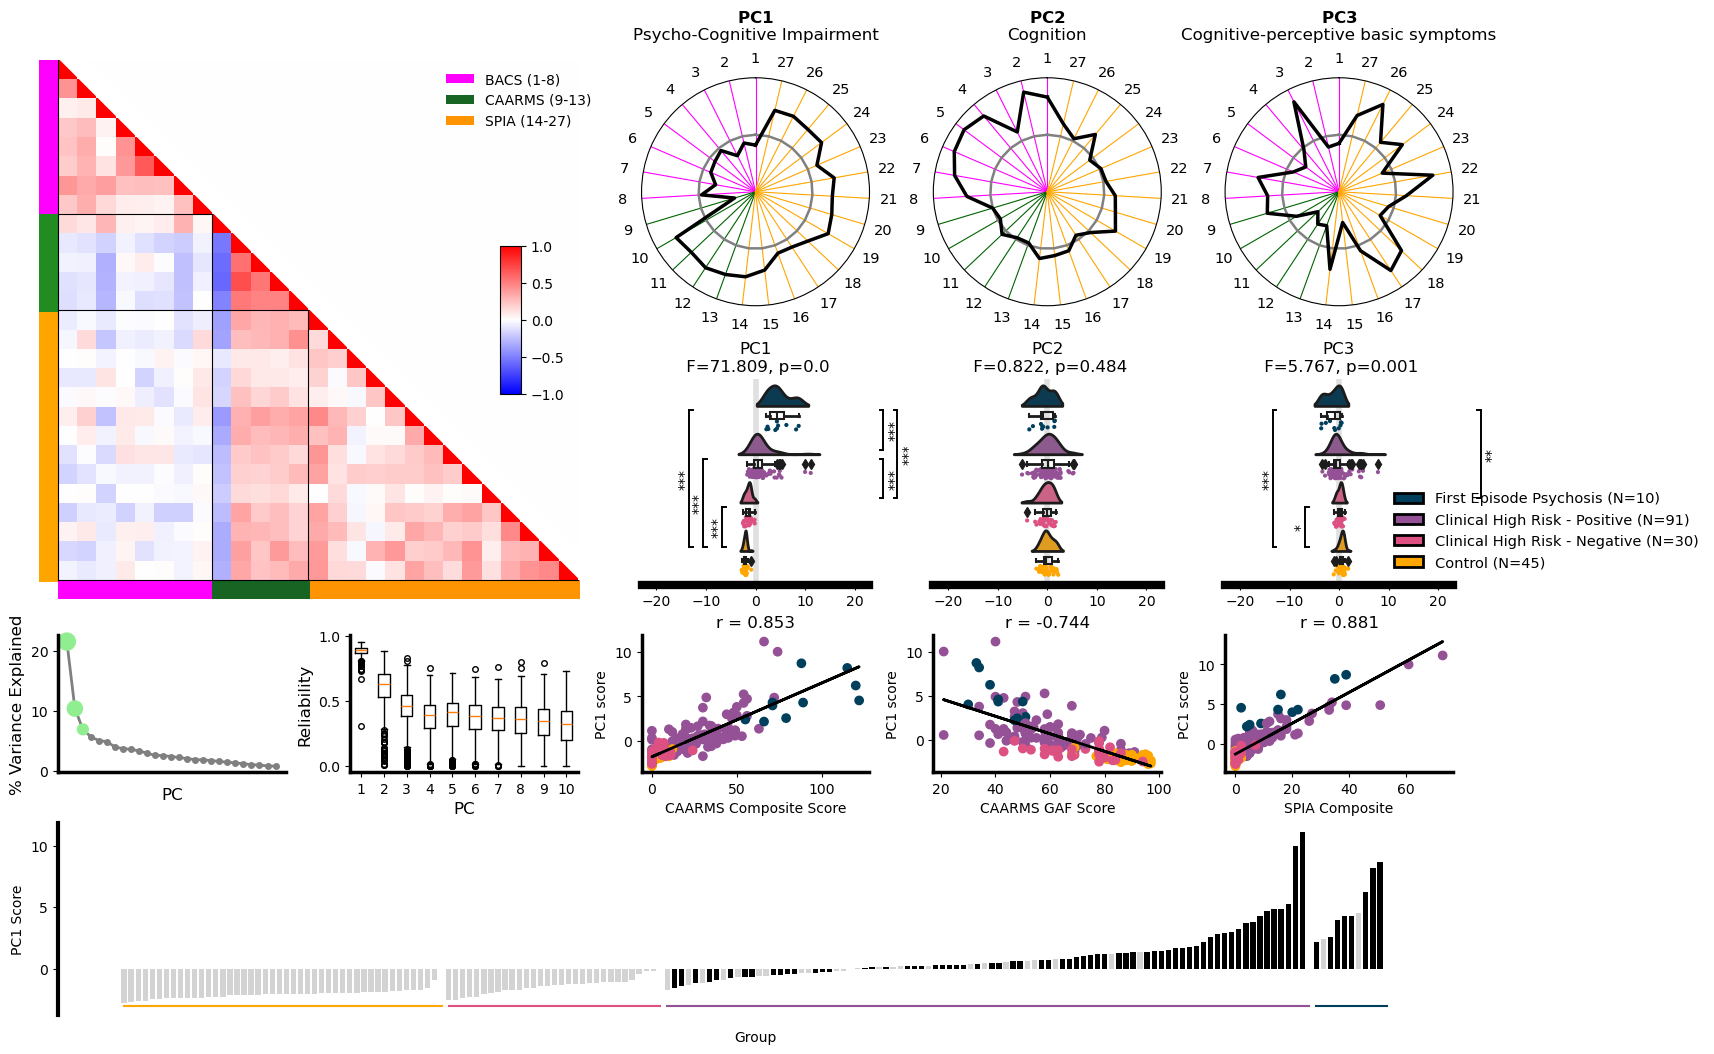

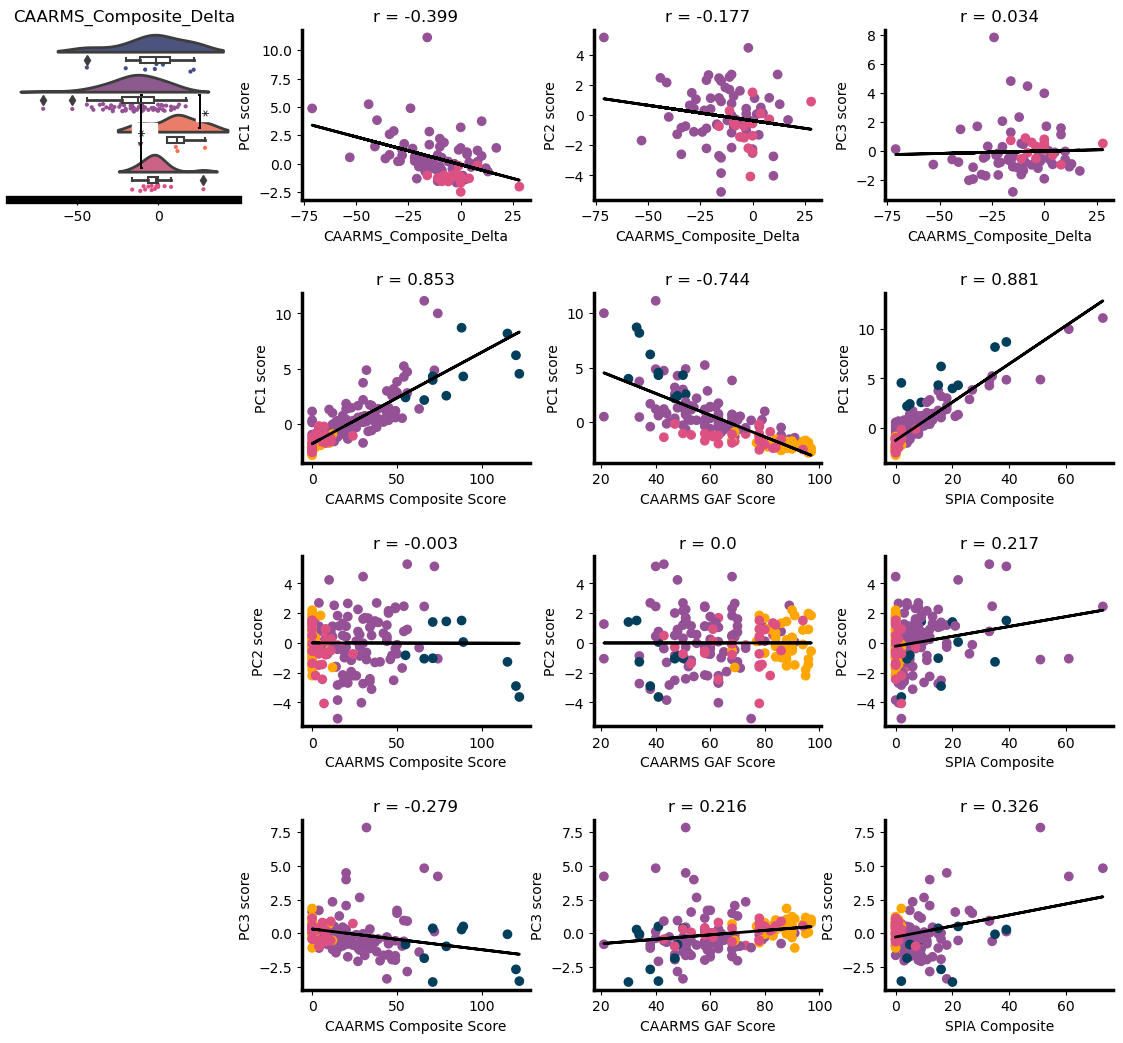

In [3]:
#WITHOUT PTT
from matplotlib import gridspec
from matplotlib.patches import Wedge
import glob

def create_plots(scores, loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[8,13,27], pcs=3):

    fig = plt.figure(figsize=(18,12))
    heights = [1,0.75,0.5, 0.7]
    widths = [1,1,1.3,1.3,1.3]
    #spec = fig.add_gridspec(ncols=5,nrows=3)
    spec = fig.add_gridspec(ncols=5,nrows=4,height_ratios=heights)
    fig.subplots_adjust(wspace=0.28, hspace=0.25, top=0.85, bottom=0.05)

    A_loc = spec[0:2,0:2]
    B_loc = [spec[0,2],spec[0,3],spec[0,4]]
    C_loc = spec[2,0]
    D_loc = spec[2,1]
    E_loc = [spec[1,2],spec[1,3],spec[1,4]]
    PC_caarms_loc = [spec[2,2],spec[2,3],spec[2,4]]
    PC_spia = spec[3,:]

    
    colors=['magenta','darkgreen','orange']
    #thresholds 
    pc_descrips = ['Psycho-Cognitive Impairment', 'Cognition', 'Cognitive-perceptive basic symptoms']
    
    cDict = {'First Episode Psychosis':"#003f5c", 'Transition to FEP':"#444e86", 'Clinical High Risk - Positive':"#955196",
            'Clinical High Risk - Negative':"#dd5182", 'Transition to HR':"#ff6e54", 'Control':"#ffa600", 'None':"#eeee0e",
                 'Transition to AP':"#ff9e30",
                 'Transition to None':"#ff5571",
                 'Remain AP':"#c040a0",
                 'AP to Psychosis Threshold':"#3b48a5"}
    
    #Dropping PTT (all group)
    scores = scores[scores['Group'] != "PTT"]
    counts_df = scores["Group"].value_counts()
    counts = []
    legendLabels = []
    cPalette = []
    for group in order:
        counts.append(counts_df[group])
        legendLabels.append(f'{group} (N={counts_df[group]})')
        cPalette.append(cDict[group])
    counts.reverse()
    
    l_data = loadings.to_numpy()
    n_vars = l_data.shape[1]

    spoke_labels = np.arange(1,n_vars+1)
    theta = radar_factory(n_vars, frame='circle')

    r_ranges = [(-10,25), (-17.5,17.5), (-20,15)]

    for pc in range(pcs):
        #Radar plot
        ax_radar = fig.add_subplot(B_loc[pc],projection='radar')
        d = l_data[pc]
        title=fr"$\bf{{PC{pc+1}}}$" "\n" f"{pc_descrips[pc]}"
        ax_radar = radar_plot(ax_radar, d, title, theta, spoke_labels, thresholds, colors)
        ax_radar.set_title(title,x=0.5,y=1.13)  
        #ax_radar.plot([0,0],[-50,50], color='red', lw=5, zorder=10)

        #Raincloud plot
        ax_rain = fig.add_subplot(E_loc[pc])
        ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
        ax_rain = rain_plot(ax_rain, scores, cPalette, order, 'Group', f'PC{pc+1}', True)
        ax_rain.set_xlim((-23,23))
        #ax_rain.set_title(f"PC{pc+1} score", size=12)
        ax_rain.set(yticklabels=[])
        ax_rain.tick_params(left=False)

    legend_elements = []
    #legendLabels.reverse()
    for i in range(len(legendLabels)):
        legend_elements.append(Patch(facecolor=cPalette[i], edgecolor='black', linewidth=2, label=legendLabels[i]))

    fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.86,0.41), frameon=False, prop={'size': 10.5})

    #Correlation plot
    ax_corr = fig.add_subplot(A_loc)
    
    ax_corr = correlation_plot(fig, ax_corr, corr_df)

    #scree plot
    
    scree_data = scree_df.to_numpy()*100 #convert to percentage
    ax_scree = fig.add_subplot(C_loc)
    #plot all PCs
    ax_scree.plot(scree_data[:,0], scree_data[:,1],'o-', markersize=4, color='grey', linewidth=2, zorder=0)
    #Significant PCs (top 3)
    ax_scree.scatter(scree_data[:3,0], scree_data[:3,1], [150,120,60], color='lightgreen', clip_on=False)
    #pie chart with proportion of explained variance
    ex_var = scree_data[:3,1].sum()

    ax_scree.set_ylabel("")
    ax_scree.set_xlabel("")
    ax_scree.spines[['right', 'top']].set_visible(False)
    ax_scree.spines.bottom.set(linewidth=2.5)
    ax_scree.spines.left.set(linewidth=2.5)
    ax_scree.set_xlabel("PC", size=12)
    ax_scree.set_ylabel("% Variance Explained", size=12)
    ax_scree.set(xticklabels=[])
    ax_scree.tick_params(bottom=False)
    ax_scree.set_xlim(left=-10)
    
    box_data = []
    labels = []
    for pc in df_box['PC'].unique():
        box_data.append(df_box['R'][df_box['PC'] == pc].to_list())
        labels.append(pc)
    ax_box = fig.add_subplot(D_loc)
    ax_box.boxplot(box_data, flierprops={'markersize':4})
    ax_box.spines[['right', 'top']].set_visible(False)
    ax_box.spines.bottom.set(linewidth=2.5)
    ax_box.spines.left.set(linewidth=2.5)
    ax_box.set_xlabel("PC", size=12)
    ax_box.set_ylabel("Reliability", size=12)

    comp_cols = ['CAARMS_UTC_severity','CAARMS_NBI_severity', 'CAARMS_PA_severity', 'CAARMS_DS_severity']
    caarms_df['CAARMS Composite'] = caarms_df[comp_cols].sum(axis=1).to_numpy()
    caarms_GAF = caarms_df['CAARMS_GAF_Score_baseline_final_score'].to_numpy()
    
    scores = pd.merge(scores, caarms_df, how='left', on='participant_id', suffixes=('', '_y'))
    groups = scores['Group'].to_list()
    caarms_colors = [cDict[g] for g in groups]

    ax_pc_caarms = fig.add_subplot(PC_caarms_loc[0])
    ax_pc_caarms.scatter(x=scores['CAARMS Composite'], y=scores[f'PC1'], c=caarms_colors)
    #Regression line
    m, b = np.polyfit(scores['CAARMS Composite'], scores[f'PC1'], 1)
    ax_pc_caarms.plot(scores['CAARMS Composite'], m*scores['CAARMS Composite']+b, c='black', lw=2.0)
    r = round(np.corrcoef(scores['CAARMS Composite'], scores[f'PC1'])[1,0],3)
    ax_pc_caarms.set_title(f'r = {r}')

    ax_pc_caarms.spines[['right', 'top']].set_visible(False)
    ax_pc_caarms.spines.bottom.set(linewidth=2.5)
    ax_pc_caarms.spines.left.set(linewidth=2.5)
    ax_pc_caarms.set_xlabel('CAARMS Composite Score')
    ax_pc_caarms.set_ylabel(f'PC1 score')
    ax_pc_caarms = fig.add_subplot(PC_caarms_loc[1])
    ax_pc_caarms.scatter(x=scores['CAARMS_GAF_Score_baseline_final_score'], y=scores[f'PC1'], c=caarms_colors)
    #Regression line
    m, b = np.polyfit(scores['CAARMS_GAF_Score_baseline_final_score'], scores[f'PC1'], 1)
    ax_pc_caarms.plot(scores['CAARMS_GAF_Score_baseline_final_score'], m*scores['CAARMS_GAF_Score_baseline_final_score']+b, c='black', lw=2.0)
    r = round(np.corrcoef(scores['CAARMS_GAF_Score_baseline_final_score'], scores[f'PC1'])[1,0],3)
    ax_pc_caarms.set_title(f'r = {r}')

    ax_pc_caarms.spines[['right', 'top']].set_visible(False)
    ax_pc_caarms.spines.bottom.set(linewidth=2.5)
    ax_pc_caarms.spines.left.set(linewidth=2.5)
    ax_pc_caarms.set_xlabel('CAARMS GAF Score')
    ax_pc_caarms.set_ylabel(f'PC1 score')

    scores['SPIA Composite'] = scores.filter(regex='SPIA').sum(axis=1)
    spia_comp = scores['SPIA Composite'].to_numpy()

    ax_spia = fig.add_subplot(PC_caarms_loc[2])
    ax_spia.scatter(x=spia_comp, y=scores[f'PC1'], c=caarms_colors)
    m, b = np.polyfit(spia_comp, scores[f'PC1'], 1)
    ax_spia.plot(spia_comp, m*spia_comp+b, c='black', lw=2.0)

    r = round(np.corrcoef(spia_comp, scores[f'PC1'])[1,0],3)
    ax_spia.set_title(f'r = {r}')

    ax_spia.spines[['right', 'top']].set_visible(False)
    ax_spia.spines.bottom.set(linewidth=2.5)
    ax_spia.spines.left.set(linewidth=2.5)
    ax_spia.set_xlabel('SPIA Composite')
    ax_spia.set_ylabel(f'PC1 score')

    id_df = pd.read_csv('../csvs/YouR_Study_All_Misc.csv')[['Study_ID','Scan_ID']].rename(columns={'Scan_ID':'participant_id'})
    uhr_df = pd.read_csv('../csvs/UHR_Misc.csv')
    mapper = {0.0:'None',1.0:'CAARMS',2.0:'SPIA',3.0:'Both'}
    uhr_df['UHR_Category'] = uhr_df['UHR_Category'].map(mapper)
    arms_df = pd.read_csv('../csvs/CAARMS_baseline.csv')[['Study_ID', 'CAARMS_group_baseline_final_score']]
    mapper_arms = {'0':'None','1':'Attenuated Psychosis Group','3':'Vulnerability Group','4':'Psychosis Threshold', '5':'Attenuated Psychosis + Vulnerability'}
    arms_df['CAARMS_group_baseline_final_score'] = arms_df['CAARMS_group_baseline_final_score'].map(mapper_arms)#.fillna(arms_df['CAARMS_group_baseline_final_score'])
    merged_df = pd.merge(id_df, uhr_df, how='left', on='Study_ID')
    merged_df = pd.merge(merged_df, arms_df, how='left', on='Study_ID').drop(columns=['Study_ID'])
    #print(scores.columns)
    scores = pd.merge(scores, merged_df, how='left', on='participant_id')
    
    cDictUHR = {'None':'lightgrey','CAARMS':'lightgrey','SPIA':'black','Both':'black'}
    order.reverse()
    ax_group = fig.add_subplot(PC_spia)
    pc1_data = []
    color_data = []
    prev=0
    for group in order:
        group_df = scores[scores['Group'] == group]
        group_df = group_df.sort_values(by=['PC1'], ascending=True)
        pc1_data += group_df['PC1'].to_list()
        #seperator
        pc1_data += [0]*1
        uhr_data = group_df['UHR_Category'].to_list()
        color_data += [cDictUHR[uhr] for uhr in uhr_data]
        color_data += ['white']*1
        #print(group_df.shape[0])
        ax_group.plot([prev,prev+group_df.shape[0]*2], [-3,-3], lw=1.5, color=cDict[group])
        prev += group_df.shape[0]*2 + 2

    x = np.arange(len(pc1_data)*2,step=2)
    ax_group.bar(x, pc1_data, width=1.5, color=color_data)
    ax_group.set(xticklabels=[])
    ax_group.tick_params(bottom=False)
    #ax_group.set(yticklabels=[])
    ax_group.spines[['right', 'top', 'bottom']].set_visible(False)
    #ax_group.spines.bottom.set(linewidth=3)
    ax_group.spines.left.set(linewidth=3)
    ax_group.set_ylabel("PC1 Score")
    ax_group.set_xlabel("Group")




    

    # ax_comp = fig.add_subplot(comp_loc)
    # ax_comp.scatter(x=caarms_comp, y=caarms_GAF, s=10, c=caarms_colors)


    plt.show()

def supplement_plots(scores, behavior, delta_df=False):
    fig = plt.figure(figsize=(18,12))
    spec = fig.add_gridspec(ncols=5,nrows=4)
    fig.subplots_adjust(wspace=0.28, hspace=0.55, top=0.85, bottom=0.05)

    delta_loc = [spec[0,0],spec[0,1],spec[0,2],spec[0,3],spec[0,4]]

    PC_caarms_loc = [[spec[1,1],spec[1,2],spec[1,3],spec[1,4]],
                     [spec[2,1],spec[2,2],spec[2,3],spec[2,4]],
                     [spec[3,1],spec[3,2],spec[3,3],spec[3,4]]]

    cDict = {'First Episode Psychosis':"#003f5c", 'Transition to FEP':"#444e86", 'Clinical High Risk - Positive':"#955196",
        'Clinical High Risk - Negative':"#dd5182", 'Transition to HR':"#ff6e54", 'Control':"#ffa600"}

    delta_order = ['Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP']
    delta_order.reverse()
    #Dropping PTT (all group)
    scores = scores[scores['Group'] != "PTT"]
    delta_counts_df = delta_df["Group"].value_counts()
    delta_counts = []
    delta_legendLabels = []
    delta_cPalette = []
    for group in delta_order:
        #delta_counts.append(delta_counts_df[group])
        delta_legendLabels.append(f'{group} (N={delta_counts_df[group]})')
        delta_cPalette.append(cDict[group])
    #delta_counts.reverse()
    

    if not isinstance(delta_df, bool):
        delta_df = pd.merge(delta_df, scores[['participant_id', 'PC1', 'PC2', 'PC3']], how='left', on='participant_id')
        
        ax_rain = fig.add_subplot(delta_loc[0])
        #ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
        ax_rain = rain_plot(ax_rain, delta_df, delta_cPalette, delta_order, 'Group', f'CAARMS_Composite_Delta', True)
        #ax_rain.set_xlim((-23,23))
        ax_rain.set_title(f"CAARMS_Composite_Delta", size=12)
        ax_rain.set(yticklabels=[])
        ax_rain.tick_params(left=False)

        delta_df = delta_df[delta_df['PC1'].notna()]

        d_groups = delta_df['Group'].to_list()
        delta_colors = [cDict[g] for g in d_groups]

        ax_delta = fig.add_subplot(delta_loc[1])
        ax_delta.scatter(x=delta_df['CAARMS_Composite_Delta'], y=delta_df[f'PC1'], c=delta_colors)
        ax_delta.spines[['right', 'top']].set_visible(False)
        ax_delta.spines.bottom.set(linewidth=2.5)
        ax_delta.spines.left.set(linewidth=2.5)
        ax_delta.set_xlabel('CAARMS_Composite_Delta')
        ax_delta.set_ylabel(f'PC1 score')
        m, b = np.polyfit(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC1'], 1)
        ax_delta.plot(delta_df['CAARMS_Composite_Delta'], m*delta_df['CAARMS_Composite_Delta']+b, c='black', lw=2.0)
        r = round(np.corrcoef(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC1'])[1,0],3)
        ax_delta.set_title(f'r = {r}')

        ax_delta = fig.add_subplot(delta_loc[2])
        ax_delta.scatter(x=delta_df['CAARMS_Composite_Delta'], y=delta_df[f'PC2'], c=delta_colors)
        ax_delta.spines[['right', 'top']].set_visible(False)
        ax_delta.spines.bottom.set(linewidth=2.5)
        ax_delta.spines.left.set(linewidth=2.5)
        ax_delta.set_xlabel('CAARMS_Composite_Delta')
        ax_delta.set_ylabel(f'PC2 score')
        m, b = np.polyfit(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC2'], 1)
        ax_delta.plot(delta_df['CAARMS_Composite_Delta'], m*delta_df['CAARMS_Composite_Delta']+b, c='black', lw=2.0)
        r = round(np.corrcoef(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC2'])[1,0],3)
        ax_delta.set_title(f'r = {r}')

        ax_delta = fig.add_subplot(delta_loc[3])
        ax_delta.scatter(x=delta_df['CAARMS_Composite_Delta'], y=delta_df[f'PC3'], c=delta_colors)
        ax_delta.spines[['right', 'top']].set_visible(False)
        ax_delta.spines.bottom.set(linewidth=2.5)
        ax_delta.spines.left.set(linewidth=2.5)
        ax_delta.set_xlabel('CAARMS_Composite_Delta')
        ax_delta.set_ylabel(f'PC3 score')
        m, b = np.polyfit(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC3'], 1)
        ax_delta.plot(delta_df['CAARMS_Composite_Delta'], m*delta_df['CAARMS_Composite_Delta']+b, c='black', lw=2.0)
        r = round(np.corrcoef(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC3'])[1,0],3)
        ax_delta.set_title(f'r = {r}')

    c_comp_cols = ['CAARMS_UTC_severity','CAARMS_NBI_severity', 'CAARMS_PA_severity', 'CAARMS_DS_severity']
    scores['CAARMS Composite'] = behavior[c_comp_cols].sum(axis=1).to_numpy()
    scores['CAARMS_GAF_Score_baseline_final_score'] = behavior['CAARMS_GAF_Score_baseline_final_score']
    groups = scores['Group'].to_list()
    caarms_colors = [cDict[g] for g in groups]

    for pc in range(3):
        ax_pc_caarms = fig.add_subplot(PC_caarms_loc[pc][0])
        ax_pc_caarms.scatter(x=scores['CAARMS Composite'], y=scores[f'PC{pc+1}'], c=caarms_colors)
        #Regression line
        m, b = np.polyfit(scores['CAARMS Composite'], scores[f'PC{pc+1}'], 1)
        ax_pc_caarms.plot(scores['CAARMS Composite'], m*scores['CAARMS Composite']+b, c='black', lw=2.0)
        r = round(np.corrcoef(scores['CAARMS Composite'], scores[f'PC{pc+1}'])[1,0],3)
        ax_pc_caarms.set_title(f'r = {r}')
        ax_pc_caarms.spines[['right', 'top']].set_visible(False)
        ax_pc_caarms.spines.bottom.set(linewidth=2.5)
        ax_pc_caarms.spines.left.set(linewidth=2.5)
        ax_pc_caarms.set_xlabel('CAARMS Composite Score')
        ax_pc_caarms.set_ylabel(f'PC{pc+1} score')

        ax_pc_caarms = fig.add_subplot(PC_caarms_loc[pc][1])
        ax_pc_caarms.scatter(x=scores['CAARMS_GAF_Score_baseline_final_score'], y=scores[f'PC{pc+1}'], c=caarms_colors)
        #Regression line
        m, b = np.polyfit(scores['CAARMS_GAF_Score_baseline_final_score'], scores[f'PC{pc+1}'], 1)
        ax_pc_caarms.plot(scores['CAARMS_GAF_Score_baseline_final_score'], m*scores['CAARMS_GAF_Score_baseline_final_score']+b, c='black', lw=2.0)
        r = round(np.corrcoef(scores['CAARMS_GAF_Score_baseline_final_score'], scores[f'PC{pc+1}'])[1,0],3)
        ax_pc_caarms.set_title(f'r = {r}')
        ax_pc_caarms.spines[['right', 'top']].set_visible(False)
        ax_pc_caarms.spines.bottom.set(linewidth=2.5)
        ax_pc_caarms.spines.left.set(linewidth=2.5)
        ax_pc_caarms.set_xlabel('CAARMS GAF Score')
        ax_pc_caarms.set_ylabel(f'PC{pc+1} score')

        scores['SPIA Composite'] = behavior.filter(regex='SPIA').sum(axis=1)
        spia_comp = scores['SPIA Composite'].to_numpy()

        ax_spia = fig.add_subplot(PC_caarms_loc[pc][2])
        ax_spia.scatter(x=spia_comp, y=scores[f'PC{pc+1}'], c=caarms_colors)
        m, b = np.polyfit(spia_comp, scores[f'PC{pc+1}'], 1)
        ax_spia.plot(spia_comp, m*spia_comp+b, c='black', lw=2.0)

        r = round(np.corrcoef(spia_comp, scores[f'PC{pc+1}'])[1,0],3)
        ax_spia.set_title(f'r = {r}')

        ax_spia.spines[['right', 'top']].set_visible(False)
        ax_spia.spines.bottom.set(linewidth=2.5)
        ax_spia.spines.left.set(linewidth=2.5)
        ax_spia.set_xlabel('SPIA Composite')
        ax_spia.set_ylabel(f'PC{pc+1} score')

    return

folder="/Users/sab322/glasgow/presentation/data"
prefix="NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_"
scores = pd.read_csv(f'{folder}/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
loadings = loadings*-1
scores[['PC1','PC2','PC3']] = scores[['PC1','PC2','PC3']] *-1
corr_df = pd.read_csv(f'{folder}/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'{folder}/behavior_PassQC_CBS_NT.tsv', sep='\t')
order = ['Control', 'Clinical High Risk - Negative', 'Clinical High Risk - Positive', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order)

delta_df = pd.read_csv('/Users/sab322/glasgow/presentation/data/behavior_followup_ALL.tsv', sep='\t')
supplement_plots(scores, caarms_df, delta_df)

PassQC analysis, with 'converted' variable (from HR to FEP), includes transition data

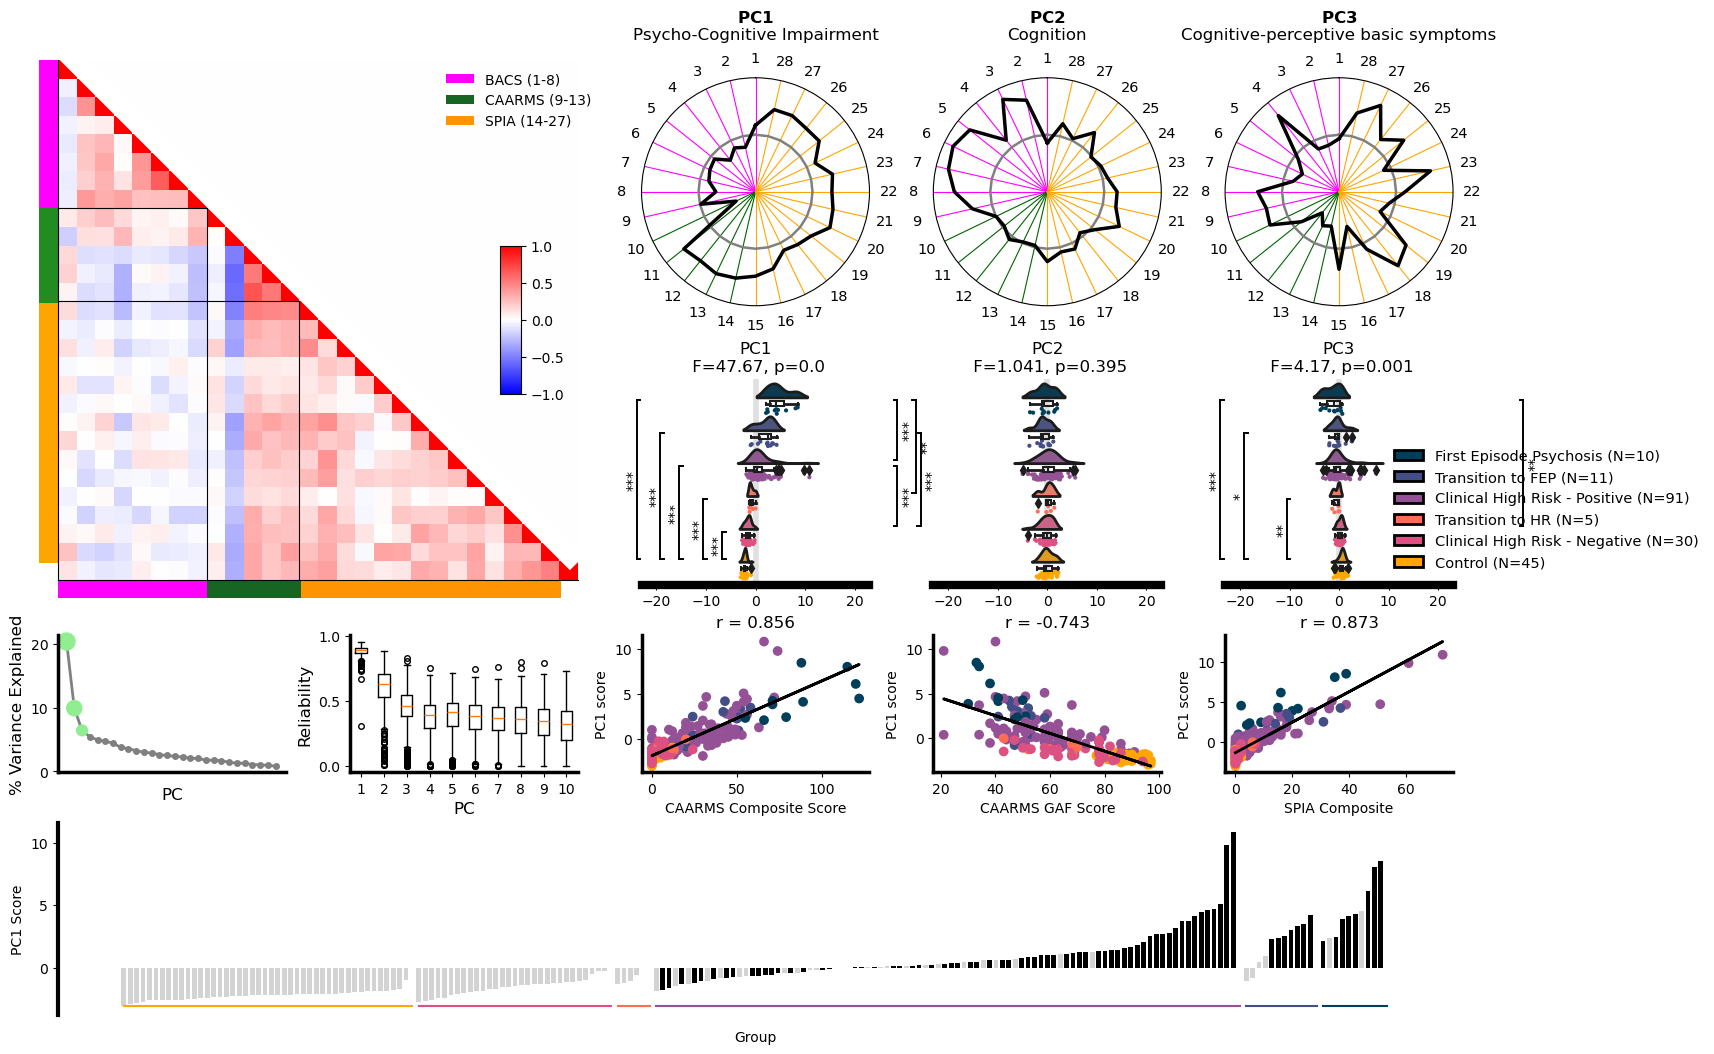

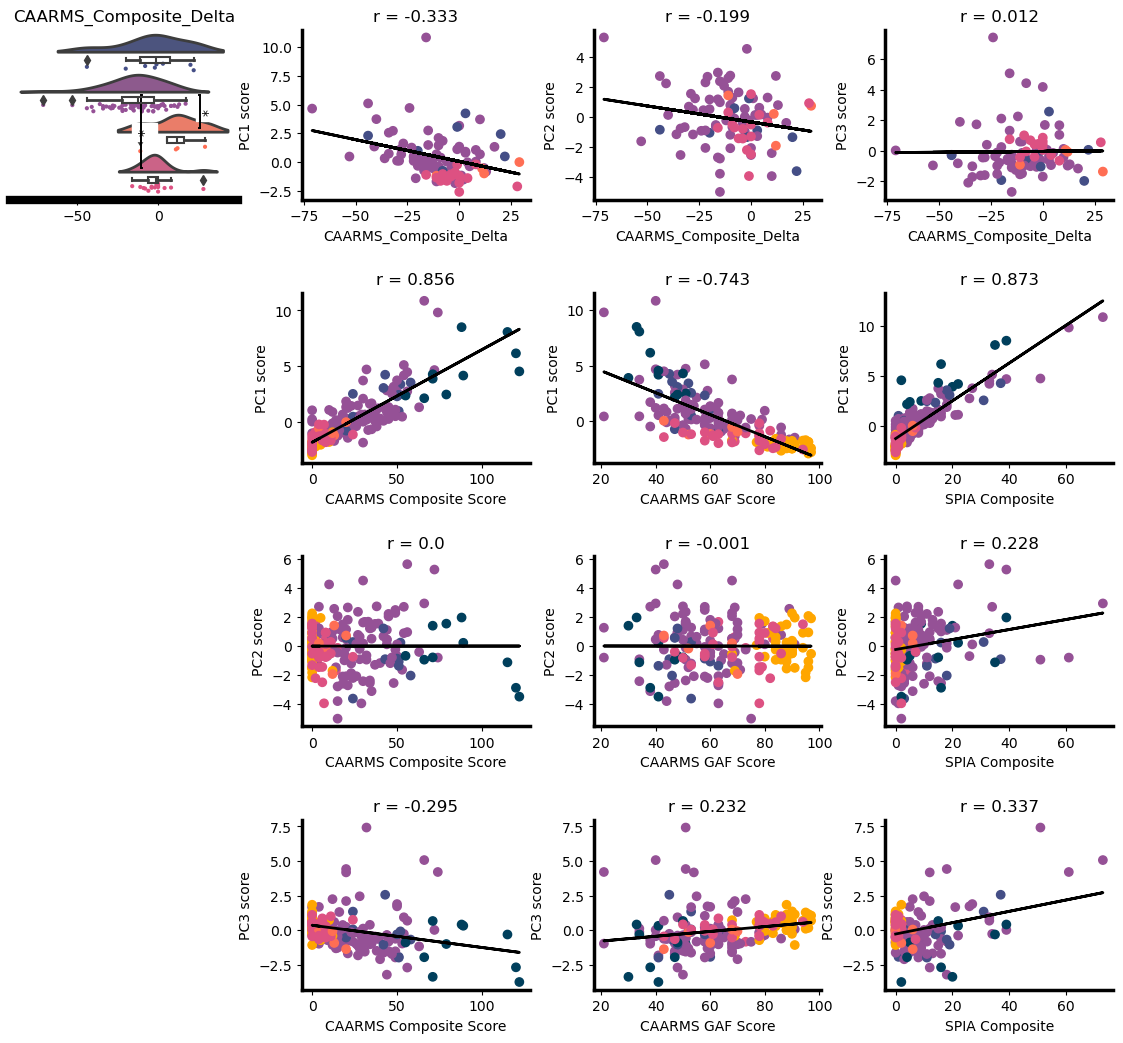

In [4]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_convert_ALL_n192/analysis"
prefix="NBRIDGE_Glasgow.collaboration_convert_ALL_n192_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
loadings = loadings*-1
loadings.iloc[2] = loadings.iloc[2] *-1
scores[['PC1','PC2']] = scores[['PC1','PC2']] *-1
corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')
order = ['Control', 'Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,14,28])
delta_df = pd.read_csv('/Users/sab322/glasgow/presentation/data/behavior_followup_ALL.tsv', sep='\t')
supplement_plots(scores, caarms_df, delta_df)

CAARMS only

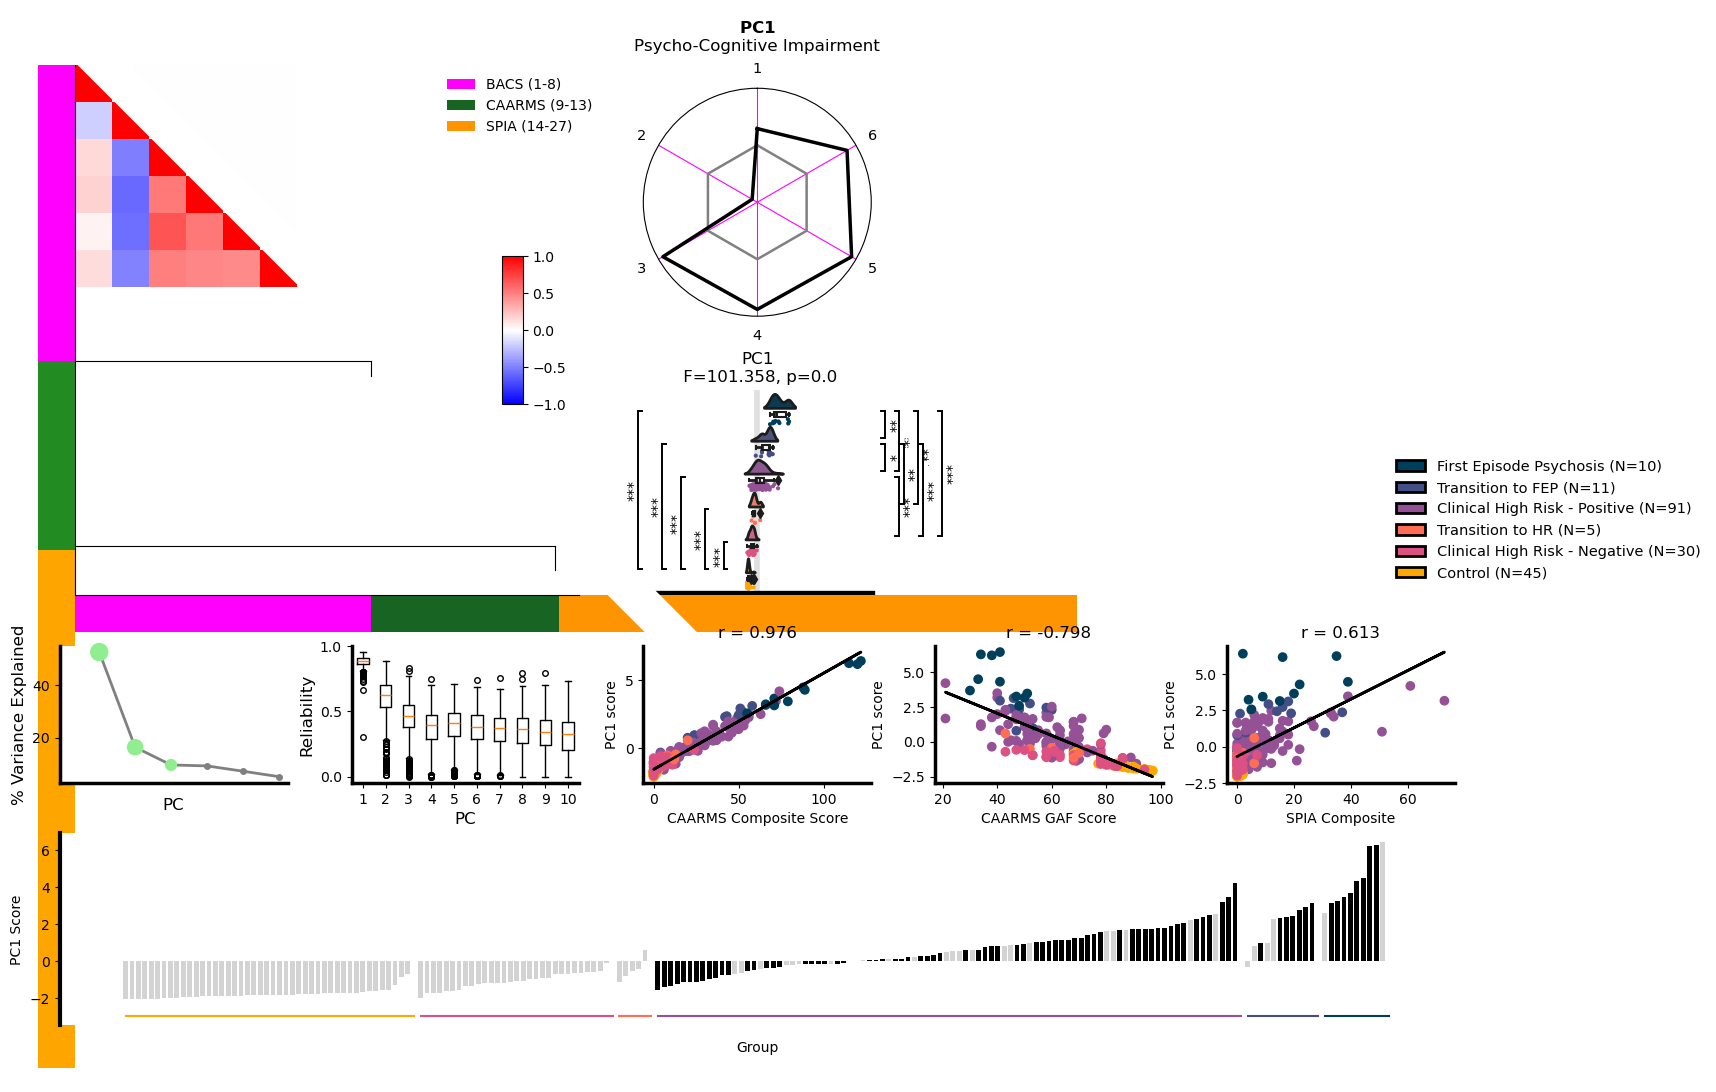

In [ ]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_baseline_CAARMS_n192/analysis"
prefix="NBRIDGE_Glasgow.collaboration_baseline_CAARMS_n192_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
#loadings = loadings*-1
#loadings.iloc[2] = loadings.iloc[2] *-1
#scores[['PC3']] = scores[['PC3']] *-1
corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')
order = ['Control', 'Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,16,30], pcs=1)

CAARMS only PC scores across timepoints

In [5]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_baseline_CAARMS_n192/analysis"
prefix="NBRIDGE_Glasgow.collaboration_baseline_CAARMS_n192_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
followup_beh = pd.read_csv('../data/caarms_followup_all_more.tsv', sep='\t')
convert_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')[['participant_id','Converted']]
followup_beh = convert_df.merge(followup_beh, how='left', on='participant_id')
from scipy.stats import zscore
numeric_cols = followup_beh.select_dtypes(include=[np.number]).columns
followup_beh[numeric_cols] = followup_beh[numeric_cols].apply(zscore)
l_arr = loadings.to_numpy()
new_scores = pd.DataFrame()
new_scores[['participant_id', 'Group']] = followup_beh[followup_beh['date']=='baseline'][['participant_id', 'Group']]
for date in followup_beh['date'].unique():
    date_df = followup_beh[followup_beh['date'] == date].copy()
    d_arr = date_df.filter(regex='Converted|CAARMS').to_numpy()
    d_scores = l_arr@d_arr.T
    date_df[f'PC1_{date}'] = d_scores[0]
    new_scores = new_scores.merge(date_df[['participant_id',f'PC1_{date}']], how='left', on='participant_id')


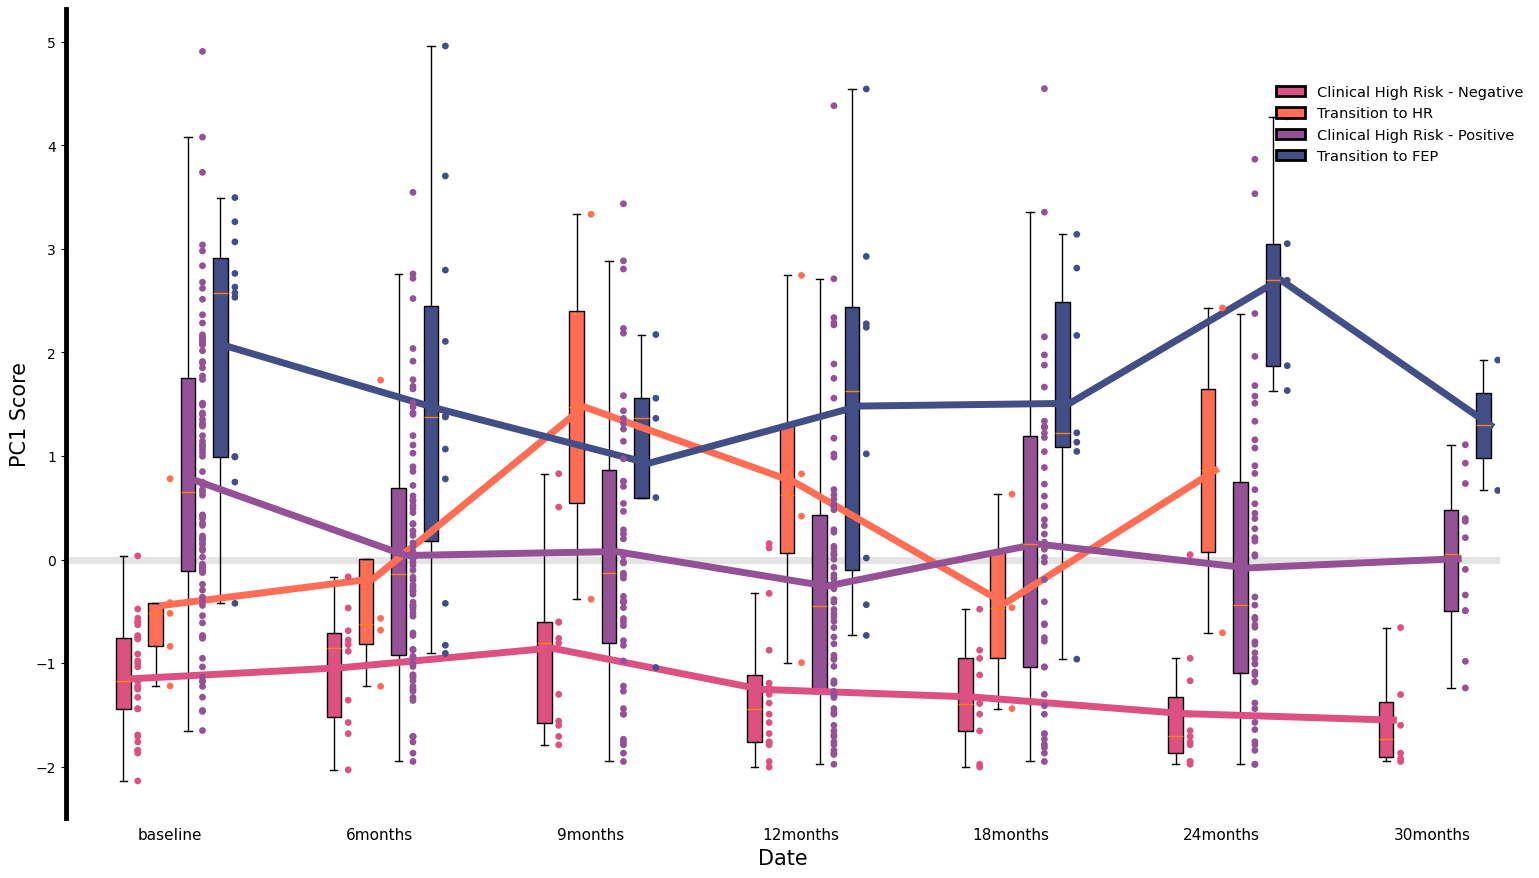

In [6]:
new_scores

order = ['Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP']
cDict = {'First Episode Psychosis':"#003f5c", 'Transition to FEP':"#444e86", 'Clinical High Risk - Positive':"#955196",
    'Clinical High Risk - Negative':"#dd5182", 'Transition to HR':"#ff6e54", 'Control':"#ffa600"}

cPalette = [cDict[group] for group in order]

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

x = 1
spacing = 6.5
jitter = 1
subspacing = 4.5

dates = ['baseline', '6months', '9months','12months', '18months', '24months', '30months']

for date in dates:
    col = f"PC1_{date}"
    box_data = []
    labels = []
    scatter = [[],[],[]]

    x_pos = [x-2*jitter,x-jitter,x,x+jitter]
    for group, x_p in zip(order, x_pos):
        y = new_scores[col][new_scores['Group'] == group].dropna().to_list()
        box_data.append(y)
        labels.append(group)
        scatter[1] += y
        scatter[0] += [x_p+jitter/subspacing] * len(y)
        scatter[2] += [cDict[group]] * len(y)

    bplot = ax.boxplot(box_data, patch_artist=True, positions=[x_p-jitter/subspacing for x_p in x_pos], vert=True, showfliers=False)
    splot = ax.scatter(scatter[0], scatter[1], c=scatter[2], zorder=50, s=15)

    x+=spacing
    for patch, color in zip(bplot['boxes'], cPalette):
        patch.set_facecolor(color)

mean_scores = []

start=1-2*jitter
for group in order:
    pc1_mean = new_scores[new_scores['Group'] == group].filter(regex='PC1').mean().to_numpy()
    x = np.arange(start, (len(pc1_mean)*spacing + start), spacing)
    mean_scores.append(pc1_mean)
    ax.plot(x, pc1_mean, c=cDict[group], label=group, lw=5)
    start += jitter

# ort = "h"; sigma = .5; cut=1.7; move=0.2; linewidth=2; 
# scale=0.85; pointplot=False
ax.spines[['right', 'top', 'bottom']].set_visible(False)
#ax.spines.bottom.set(linewidth=3.5)
ax.spines.left.set(linewidth=3.5)

label_offset = 0.2

ax.set_xticks(np.arange(label_offset, (len(dates)*spacing+label_offset), spacing))
ax.set_xticklabels(dates, size=11)
ax.xaxis.set_ticks_position('none')
ax.set_xlim(-3)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("PC1 Score", size=15)

legend_elements = []
#legendLabels.reverse()
for i in range(len(order)):
    legend_elements.append(Patch(facecolor=cPalette[i], edgecolor='black', linewidth=2, label=order[i]))

xmin = ax.get_xlim()[0]
xmax = ax.get_xlim()[1]
ax.plot([xmin,xmax], [0,0], c='lightgrey', lw=5, zorder=0, alpha=0.6)
fig.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(0.92,0.82), frameon=False, prop={'size': 10.5})
# ax=pt.RainCloud(x = 'Group', y = 'PC1_baseline', data = df, palette = cPalette, bw = sigma, cut=cut, order=order, pointplot=pointplot,
#                     width_viol = scale, ax = ax, orient = ort, move = move, scale="width", linewidth = linewidth, linecolor="red")
plt.show()

controls analysis

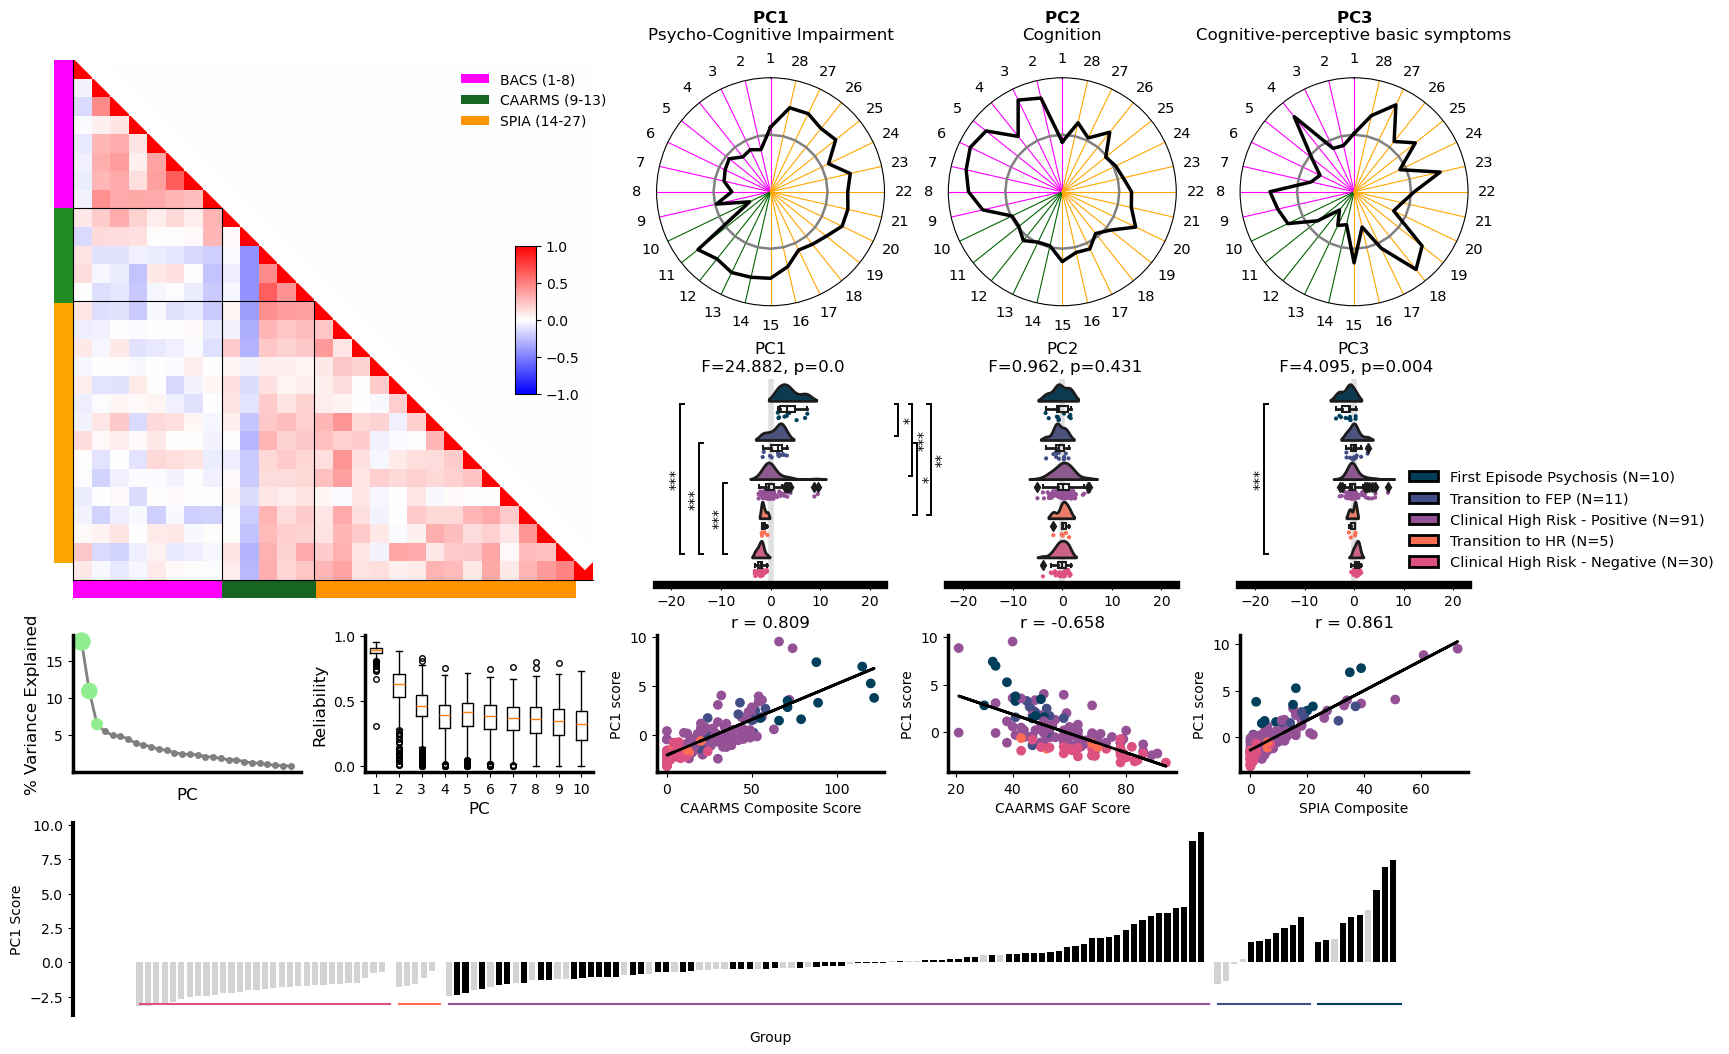

ValueError: Length of values (192) does not match length of index (147)

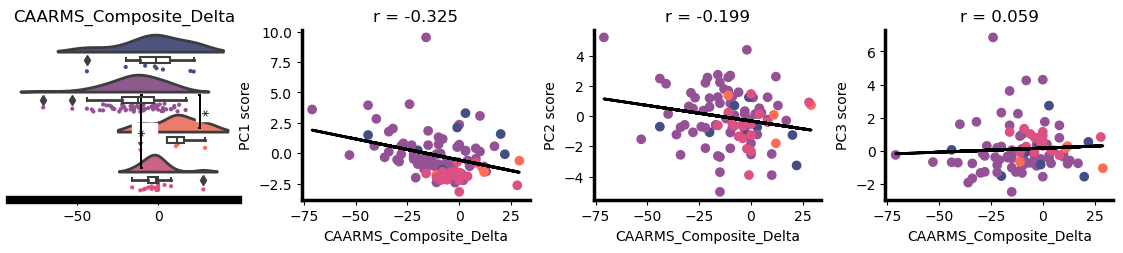

In [7]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_convert_NCON_control_analysis/analysis"
prefix="NBRIDGE_Glasgow.collaboration_convert_NCON_control_analysis_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
#loadings = loadings*-1
#loadings.iloc[2] = loadings.iloc[2] *-1
#scores[['PC1','PC2']] = scores[['PC1','PC2']] *-1
corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')
order = ['Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,14,28])
delta_df = pd.read_csv('/Users/sab322/glasgow/presentation/data/behavior_followup_ALL.tsv', sep='\t')
supplement_plots(scores, caarms_df, delta_df)

In [11]:
caarms_df[caarms_df['Group'] != 'Control']['participant_id'].to_list()

['BDA15',
 'CMH10',
 'APS28',
 'JSA14',
 'HSS25',
 'SOY01',
 'LSA15',
 'LNY21',
 'DPH26',
 'KKE31',
 'IKL25',
 'MLA02',
 'MSN18',
 'TDM20',
 'DGA23',
 'RSY28',
 'EMN05',
 'LAN19',
 'JWM12',
 'JOS07',
 'JWE04',
 'SPA08',
 'MNA13',
 'ECS22',
 'CCD08',
 'MRR15',
 'SBH06',
 'SPH15',
 'CBN30',
 'MET01',
 'JTL19',
 'WJA04',
 'HCA20',
 'CRA08',
 'KHR12',
 'APS24',
 'COR26',
 'ACA25',
 'NSA14',
 'CBR23',
 'KHE24',
 'DKY26',
 'ASA16',
 'AHH29',
 'EAN11',
 'NBA31',
 'ASA10',
 'IYH23',
 'CGE10',
 'IPA29',
 'ECY13',
 'ANA12',
 'DMY21',
 'JNA10',
 'AJD05',
 'SHM13',
 'AWN26',
 'JBY28',
 'VGN27',
 'SWE10',
 'PFE01',
 'AFE08',
 'SKG07',
 'CPA13',
 'DJA25',
 'MME01',
 'AGA24',
 'CMI09',
 'KSA25',
 'AKZ09',
 'KGA16',
 'CCK18',
 'RLR21',
 'CMT28',
 'KLS13',
 'MRA28',
 'LTA27',
 'VBE10',
 'JGH05',
 'LCR23',
 'SHE02',
 'SBE14',
 'KMA25',
 'MHH11',
 'IWN27',
 'CSY30',
 'SME15',
 'FTA10',
 'AMY05',
 'LBH20',
 'PMA23',
 'CTL27',
 'HBS04',
 'KKA23',
 'MGH25',
 'SCY22',
 'EHA05',
 'KGM25',
 'CBW09',
 'MMM14',
